In [36]:
import warnings
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Lambda
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch import nn

warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_openml
name_of_dataset = "one-hundred-plants-shape"  # название вашего датасета из таблицы
data = fetch_openml(name=name_of_dataset)

In [37]:
X = data.data
X['y'] = data.target

test_slices = []
num_of_classes = len(data.target.unique())

for i in range(1, num_of_classes+1):
  class_slice = X[X['y'] == str(i)][-1:]
  indexes_to_delete = class_slice.index

  test_slices.append(class_slice)
  X.drop(index=indexes_to_delete, inplace=True)

train_df = X.reset_index(drop=True)
train_df['y'] = train_df['y'].astype(int)

test_df = pd.concat(test_slices).reset_index(drop=True)
test_df['y'] = test_df['y'].astype(int) - 1


# Displaying shapes of train and test sets
print(f"Train set shape: {train_df.shape}\nTest set shape: {test_df.shape}")

Train set shape: (1500, 65)
Test set shape: (100, 65)


In [38]:
# Creating Dataset class for our DataLoader

from sklearn.preprocessing import StandardScaler

class DataSet(Dataset):
  def __init__(self, data):
    scaler = StandardScaler()
    self.data = data

    x = scaler.fit_transform(self.data.iloc[:, :-1].values * 10000)
    y = self.data.iloc[:, -1:].values

    self.x_train = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    self.y_train = torch.tensor(y, dtype=torch.long) - 1

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self, index):
    return self.x_train[index], self.y_train[index]

In [39]:
# Creating DataLoader

plants_data = DataSet(train_df)
train_loader = DataLoader(plants_data, batch_size=25, shuffle=True)

In [57]:
# Defining a neural network

class PlantsNeuralNetwork(nn.Module):
  def __init__(self):
    super(PlantsNeuralNetwork, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(64, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 100)
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [41]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    # 1. Forward pass
    pred = model(X)

    # 2. Evaluating loss
    y = y.squeeze()
    loss = loss_fn(pred, y)
    
    # 3. Backward pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return loss.item()

def calculate_accuracy(test_df, model):
  scaler = StandardScaler()

  x = torch.tensor(scaler.fit_transform(test_df.iloc[:, :-1].values * 10000), dtype=torch.float32)

  pred_classes = torch.softmax(model(x), dim=1).argmax(dim=1)
  y_right = torch.tensor(test_df['y'].values)

  a = pred_classes == y_right
  return a.sum() / len(a)

Training model process.


  0%|          | 0/270 [00:00<?, ?it/s]

(0.0, 1.0)

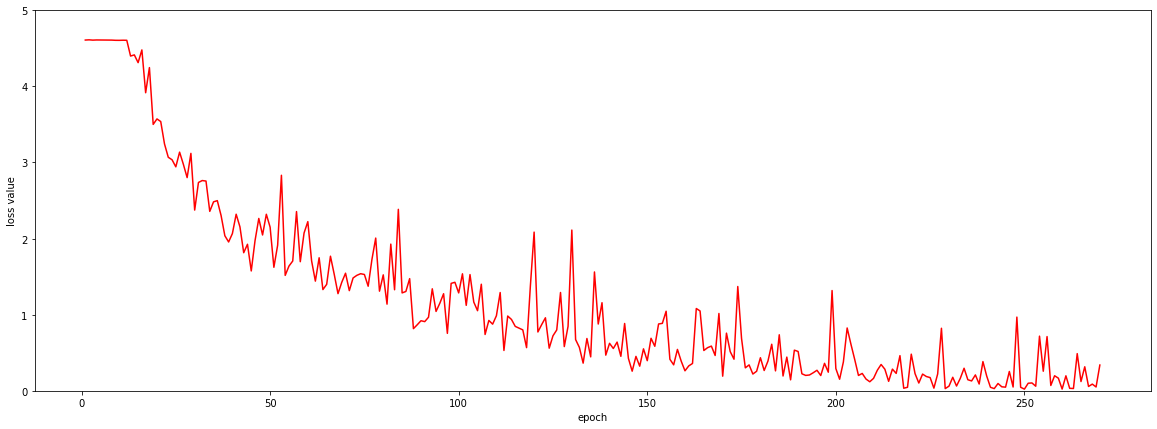

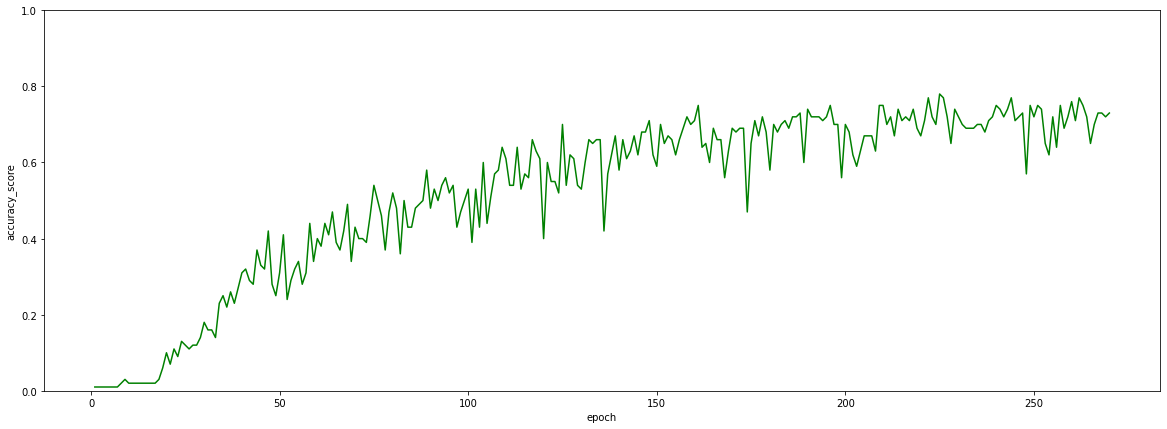

In [58]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

model = PlantsNeuralNetwork()
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_list = []
accuracy_list = []
current_epoch = []

epochs = 270

print('Training model process.')
for epoch in tqdm(range(1, epochs+1)):
  loss = train_loop(train_loader, model, loss_fn, optimizer)

  loss_list.append(loss)
  current_epoch.append(epoch)

  accuracy = round(calculate_accuracy(test_df, model).item(), 2)
  accuracy_list.append(accuracy)

# plotting loss values per each epoch
plt.figure(0, figsize=(20,7))
plt.plot(current_epoch, loss_list, color='red')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.ylim(0, 5)

# plotting accuracy per each epoch
plt.figure(1, figsize=(20,7))
plt.plot(current_epoch, accuracy_list, color='green')
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
plt.ylim(0, 1)

In [60]:
# Тестирование различных гипрепараметров
hyperparams_test = pd.DataFrame({'epochs': [300, 300, 300, 300, 300, 250, 250, 250, 270],
                                 'layers': [6, 6, 6, 6, 6, 7, 8, 8, 8],
                                 'num_of_nodes': [1024,1024,1024,1024,1024,1024,1024,1024,2048],
                                 'test_set': [200, 200, 200, 200, 200, 200, 200, 100, 100],
                                 'batch_size': [64, 128, 32, 16, 25, 25, 25, 25, 25],
                                 'learning_rate': [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.1, 0.1],
                                 'model_accuracy': ['71%', '63%', '74%', '73%', '75%', '72%', '62%', '75%', '74%'],
                                 'train_time': ['9:58', '9:51', '11:31', '16:35', '11:52', '12:23', '13:11', '13:46', '54:43']})

display(hyperparams_test.sort_values(by='model_accuracy', ascending=False))
print(model)

,epochs,layers,num_of_nodes,test_set,batch_size,learning_rate,model_accuracy,train_time
4,300,6,1024,200,25,0.2,75%,11:52
7,250,8,1024,100,25,0.1,75%,13:46
2,300,6,1024,200,32,0.2,74%,11:31
8,270,8,2048,100,25,0.1,74%,54:43
3,300,6,1024,200,16,0.2,73%,16:35
5,250,7,1024,200,25,0.2,72%,12:23
0,300,6,1024,200,64,0.2,71%,9:58
1,300,6,1024,200,128,0.2,63%,9:51
6,250,8,1024,200,25,0.3,62%,13:11


PlantsNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): ReLU()
    (14): Linear(in_features=1024, out_features=1024, bias=True)
    (15): ReLU()
    (16): Linear(in_features=1024, out_features=100, bias=True)
  )
)


Проделав множество тестов с регулировкой гиперпарамтеров, можно сделать довольно логичные выводы:
- Размер передаваемого батча является важным параметром при обучении модели. Чем больше размер батча, тем быстрее обучится модель, но точность получится ниже, и наоборот
- Размер learning_rate является один из самых главных гиперпараметров. Как правило, learning_rate варьируется от 0 до 1. Проделав тесты, стало понятно, что learning_rate в районе 0.1-0.3 является самым базовым выбором и при этом достаточно хорошо обучает модель
- Количество данных при обучении так же является важным параметром. Например, если модель имеет сложную структуру и при этом количество тренировочных данных небольшое, то точность модели будет не совсем удачной. Конечно же чем больше данных, тем лучше. В данной задаче изначально данные были поделены на 1400 тренировочных наблюдений и 200 тестовых. После этого значения были изменены на 1500, 100 соответственно и точность модели незначительно увеличилась, что говорит о том, что размер тренировочного сета вносит свой непосредственный вклад в обучение модели.
- Необязательно проходить через большое количество эпох. Например в нашем случая, проделав несколько тестов и, посмотрев на графики, было замечено, что после ~250 эпохи ошибка и точность особо никак не изменялись, либо начинались выбросы на графиках
- В конечном итоге, получилось достичь точности модели в 74%-75%. Я считаю, что данных не хвататет, чтобы еще лучше обучить модель

